In [1]:
from IFD_tsne import *
from utils import load_data, MidpointNormalize, equipotential_standard_normal, plot_heatmaps
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from tueplots import figsizes, fonts, bundles
from tueplots import cycler
from tueplots.constants import markers
from tueplots.constants.color import palettes
import tsne_jax

# Increase the resolution of all the plots below
plt.rcParams.update({"figure.dpi": 150})
from jax.config import config
config.update("jax_enable_x64", True)

# Implicit function differentiation

## Dataset

In [73]:
X, y = make_blobs(n_samples=50, n_features=50, centers=4, random_state=0, shuffle=False, cluster_std=[0.1, 3, 3, 3])
X, y = load_data(50)
key = random.PRNGKey(42)
#X = onp.array(random.normal(key, shape=(50, 50)))
y_guess = random.normal(key, shape=(X.shape[0], 2))
#Y_star = TSNE(n_components=2, learning_rate=200, init=onp.array(y_guess), perplexity=30).fit_transform(X)
Y_star = tsne_fwd(X, y_guess)
#Y_star = tsne(X, no_dims=2, initial_dims=50, perplexity=30.0, learning_rate=200, max_iter = 1000, exaggeration=4., key=42)
dy, H, J = d_y_star_d_x_outer(KL_divergence, X, Y_star)

===> Finding 49 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function


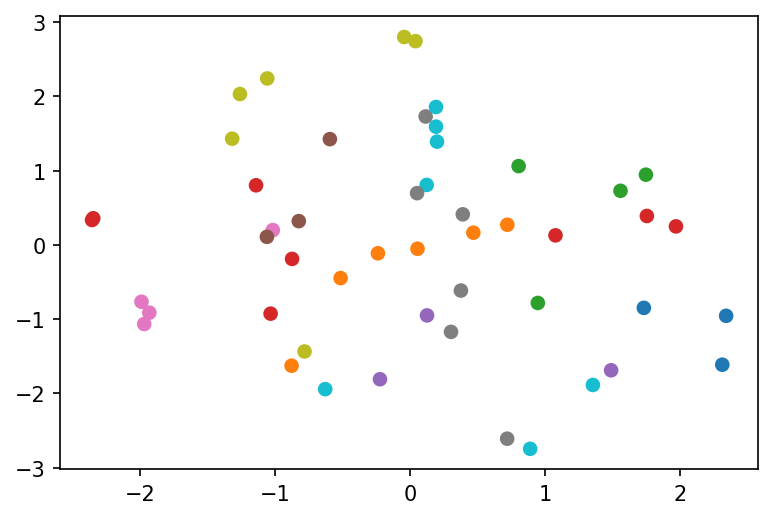

In [74]:
plt.scatter(Y_star[:, 0], Y_star[:, 1], c=y, cmap='tab10')

[2.95930047e-02 2.92742702e-02 2.88126091e-02 2.80497933e-02
 2.74868975e-02 2.73464873e-02 2.69932340e-02 2.67273042e-02
 2.63670222e-02 2.62921768e-02 2.60461565e-02 2.56969669e-02
 2.53064813e-02 2.48342208e-02 2.45508259e-02 2.42411376e-02
 2.41638898e-02 2.40295265e-02 2.39347690e-02 2.37934328e-02
 2.32850310e-02 2.28820900e-02 2.25628541e-02 2.23128380e-02
 2.20542757e-02 2.16323976e-02 2.14580408e-02 2.09759892e-02
 2.05055818e-02 2.00430294e-02 1.99483490e-02 1.99020034e-02
 1.98632847e-02 1.96234740e-02 1.89421272e-02 1.88109358e-02
 1.86441177e-02 1.83343130e-02 1.80132946e-02 1.77003178e-02
 1.73736802e-02 1.68520468e-02 1.65852670e-02 1.64660011e-02
 1.63258309e-02 1.62704952e-02 1.57474829e-02 1.57057509e-02
 1.55849402e-02 1.53115303e-02 1.49281805e-02 1.48541856e-02
 1.47730355e-02 1.42179507e-02 1.41258369e-02 1.39637141e-02
 1.37110868e-02 1.33651963e-02 1.30125480e-02 1.29243339e-02
 1.28250439e-02 1.24760037e-02 1.21452648e-02 1.19927835e-02
 1.17340019e-02 1.160214

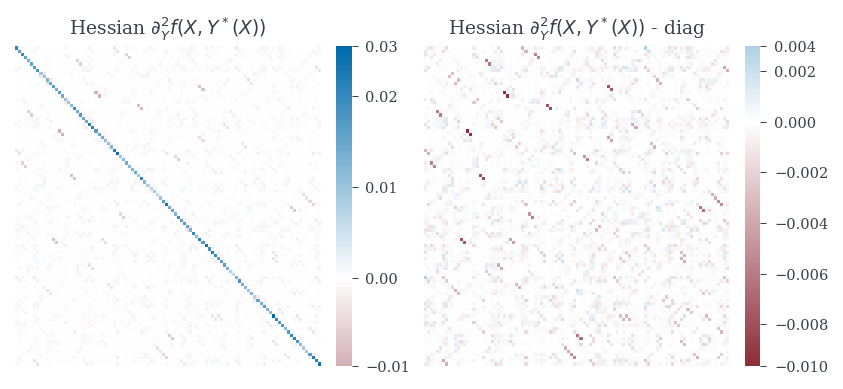

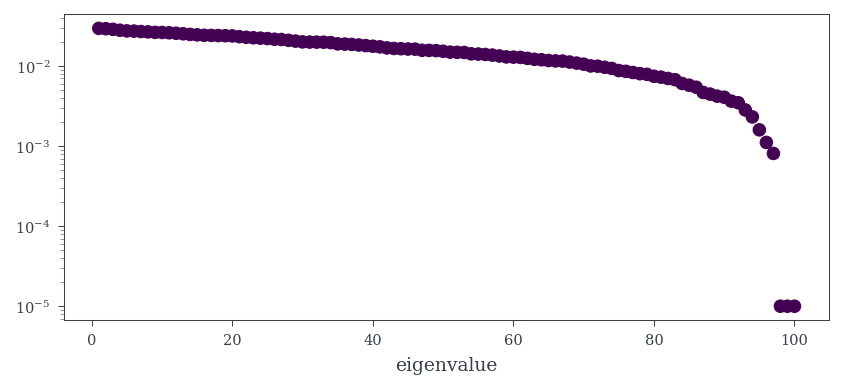

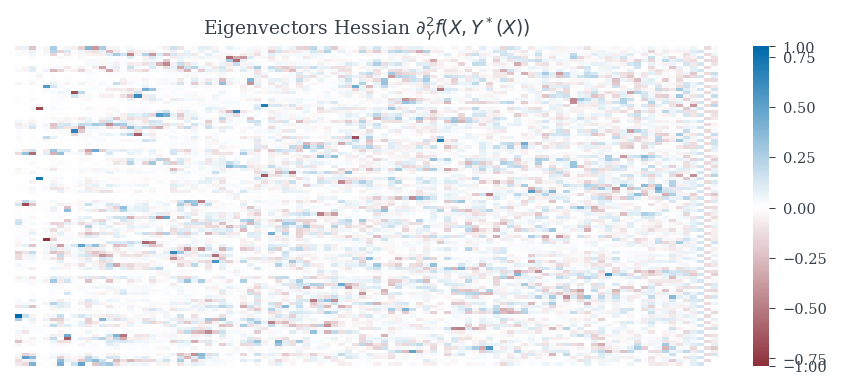

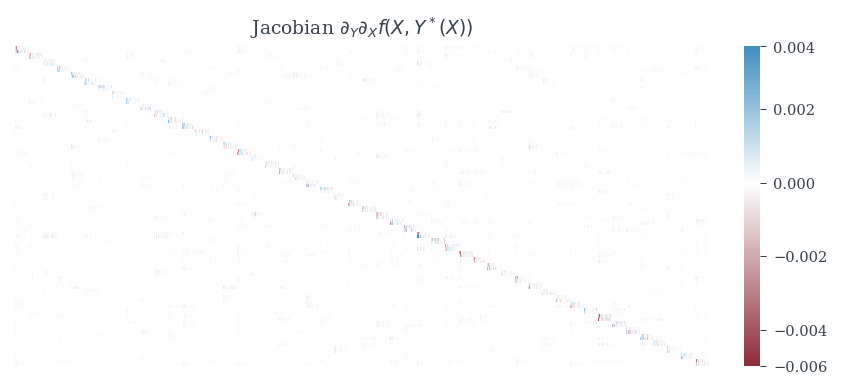

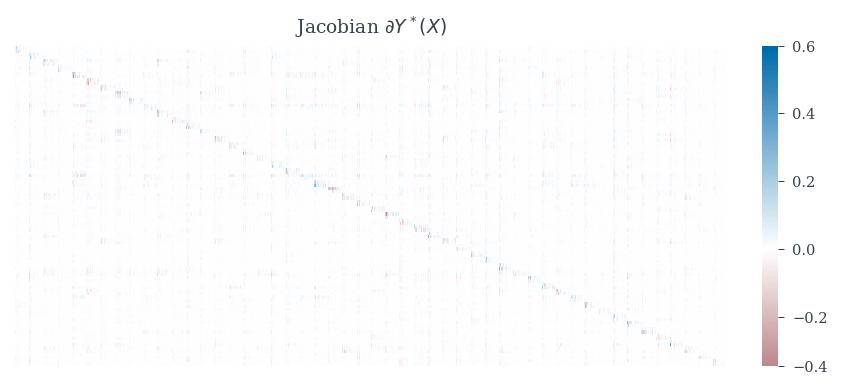

In [76]:
plot_heatmaps(dy, H, J)

In [77]:
J.shape

(100, 2500)

# Uncertainty propagation

In [78]:
lu, piv= jax.scipy.linalg.lu_factor(H+1e-5*np.eye(len(H)))
dy = jax.scipy.linalg.lu_solve((lu, piv), -J)

In [79]:
cov_X = 1e-1*np.eye(X.shape[0]*X.shape[1])

In [80]:
cov_Y = np.dot(np.dot(dy, cov_X), np.transpose(dy))
cov_Y = cov_Y+1e-5*np.eye(len(cov_Y))

In [81]:
S = equipotential_standard_normal(2 * Y_star.shape[0], 20)
L, lower = jax.scipy.linalg.cho_factor(cov_Y, lower=True)
Y_star_flat, Y_unflattener = flatten_util.ravel_pytree(Y_star)
samples = np.transpose(np.transpose(np.dot(L, S))+Y_star_flat)

/mnt/qb/work/coe/szabel09/src/tsne/utils.py:82: RuntimeWarning: invalid value encountered in true_divide
  M = np.dot(mu, np.expand_dims(np.cos(theta), axis=0)) + E * np.sin(theta) / theta


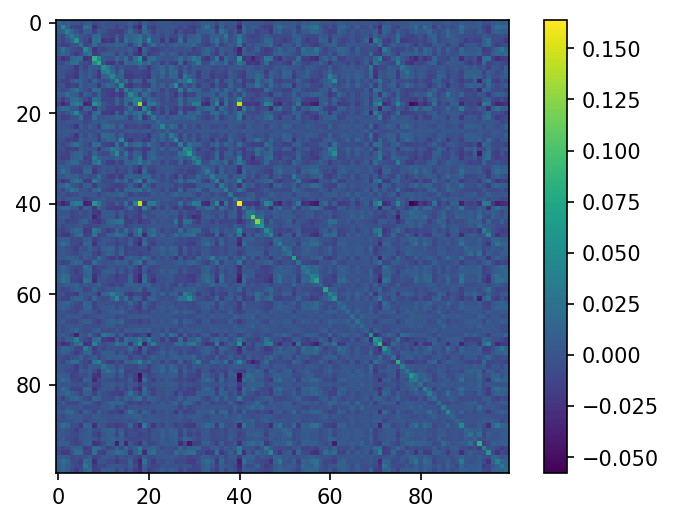

In [82]:
plt.imshow(cov_Y)
plt.colorbar()

In [71]:
np.save('ifd_results/samples.npy', samples)
np.save('ifd_results/labels.npy', y)

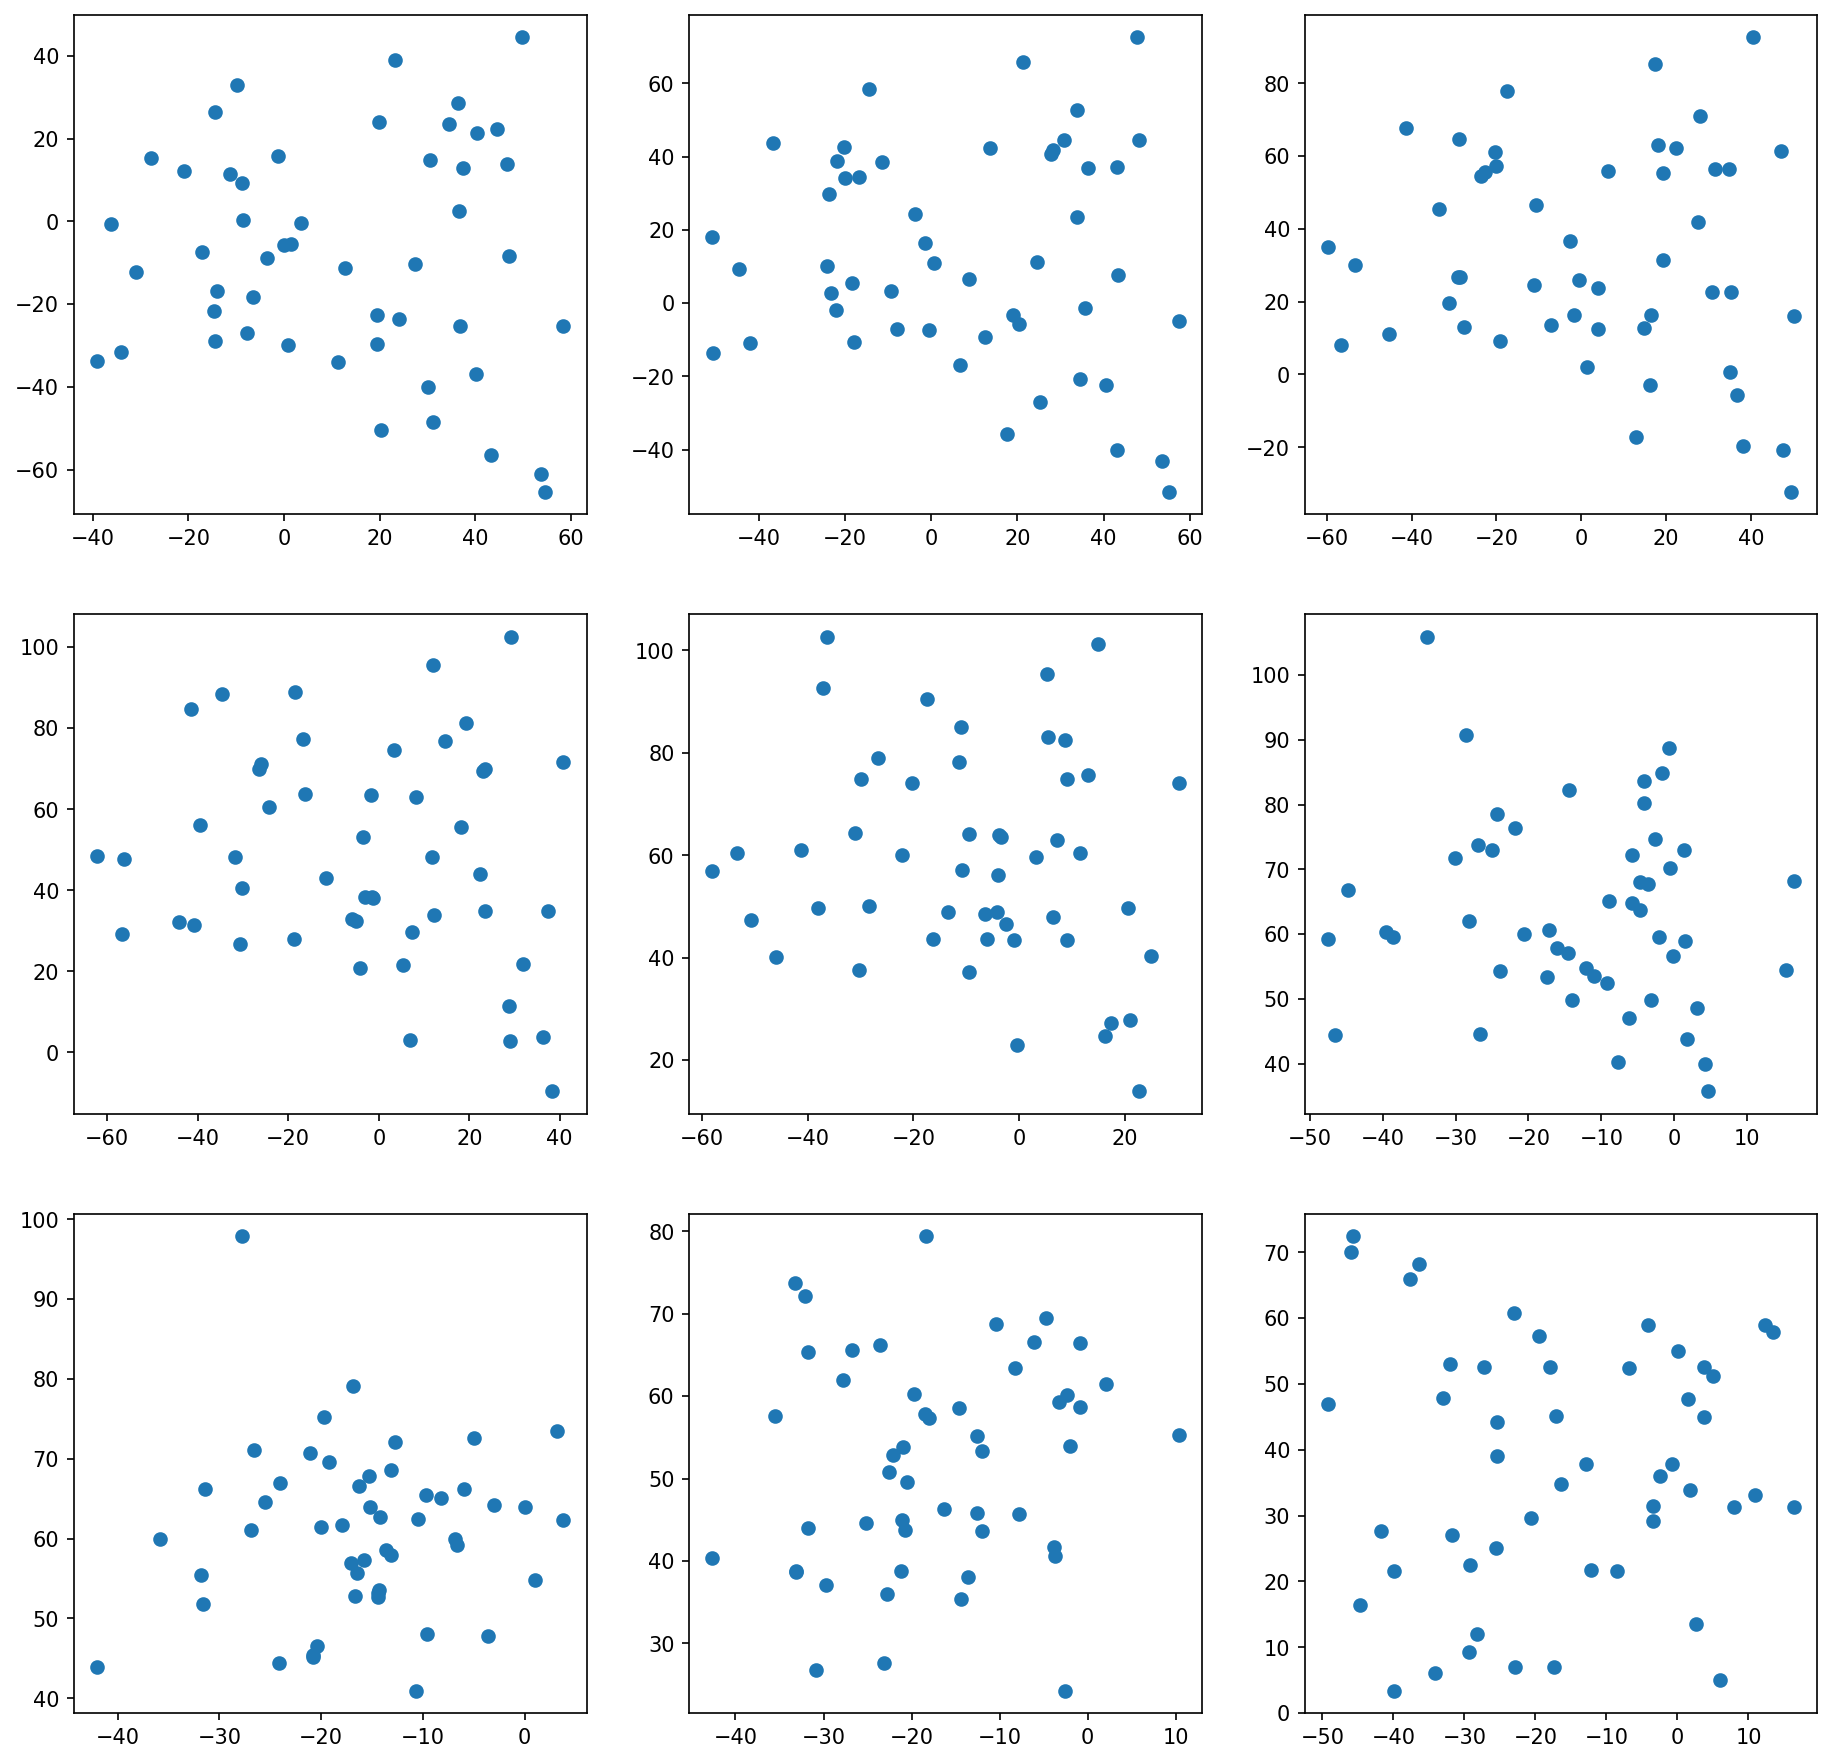

In [22]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
for i, ax in zip(np.transpose(samples), axs.ravel()):
    Y_sample = Y_unflattener(i)
    ax.scatter(Y_sample[:, 0], Y_sample[:, 1])

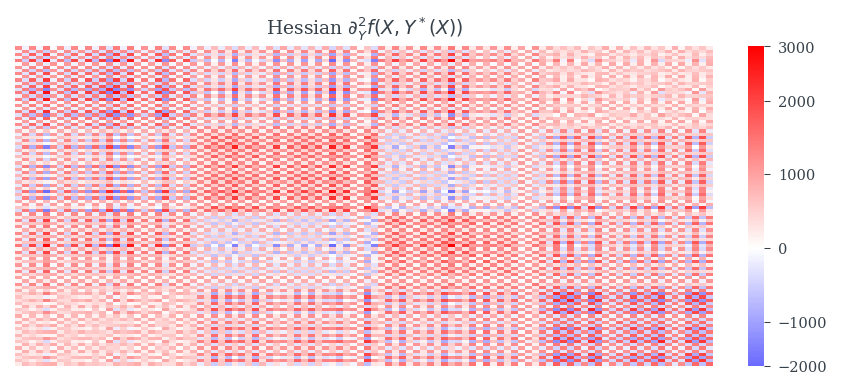

In [23]:
with plt.rc_context(bundles.beamer_moml()):
    fig, ax1 = plt.subplots()
    sns.heatmap(H_inv, cmap='bwr', norm=(MidpointNormalize(midpoint=0, vmin=onp.min(H_inv), vmax=onp.max(H_inv))), ax=ax1)
    ax1.set_title('Hessian $\partial_Y^2 f(X, Y^*(X))$')
    ax1.tick_params(bottom=False, left=False)
    ax1.set(xticklabels=[], yticklabels=[])

In [24]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("", [palettes.tue_plot[0], "white", palettes.tue_plot[3]])

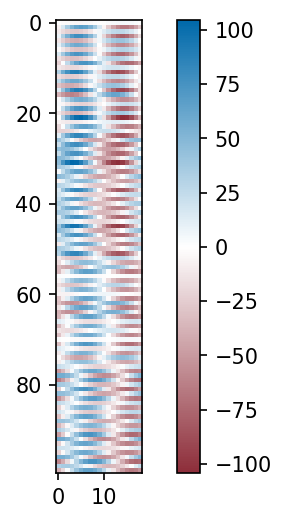

In [25]:
plt.imshow(np.dot(L, S), cmap=cmap)
plt.colorbar()

In [12]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("", [palettes.tue_plot[0], "white", palettes.tue_plot[3]])

def plot_heatmaps(dy=None, H=None, J=None): 
    if H is not None:
        with plt.rc_context(bundles.beamer_moml()):
            fig, (ax1, ax2) = plt.subplots(1, 2)
            sns.heatmap(H, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H), vmax=np.max(H))), ax=ax1)
            ax1.set_title('Hessian $\partial_Y^2 f(X, Y^*(X))$')
            ax1.tick_params(bottom=False, left=False)
            ax1.set(xticklabels=[], yticklabels=[])
            sns.heatmap(H-np.diag(np.diag(H)), cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H-np.diag(np.diag(H))), vmax=np.max(H-np.diag(np.diag(H))))), ax=ax2)
            ax2.set_title('Hessian $\partial_Y^2 f(X, Y^*(X))$ - diag')
            ax2.tick_params(bottom=False, left=False)
            ax2.set(xticklabels=[], yticklabels=[])
            plt.savefig('ifd_results/Hessian.pdf')
        v, w = np.linalg.eigh(H)
        w_sorted = np.transpose(np.transpose(w)[np.flip(np.argsort(v))])
        with plt.rc_context(bundles.beamer_moml()):
            fig, (ax1, ax2) = plt.subplots(1, 2)
            ax1.set_title('Eigenvalues Hessian $\partial_Y^2 f(X, Y^*(X))$')
            ax1.scatter([i for i in range(1, len(v)+1)], np.flip(np.sort(np.abs(v))))#, c=[1 if i>0 else 0 for i in np.flip(np.sort(v))])
            ax1.set_xlabel('eigenvalue')
            ax1.set_yscale('log')
            sns.heatmap(w_sorted, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(w_sorted), vmax=np.max(w_sorted))), ax=ax2)
            ax2.set_title('Eigenvectors Hessian $\partial_Y^2 f(X, Y^*(X))$')
            ax2.tick_params(bottom=False, left=False)
            ax2.set(xticklabels=[], yticklabels=[])
            plt.savefig('ifd_results/Eigendecomposition_Hessian.pdf')
    if J is not None:
        with plt.rc_context(bundles.beamer_moml()):
            fig, ax1 = plt.subplots()
            sns.heatmap(J, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(J), vmax=np.max(J))), ax=ax1)
            ax1.set_title('Jacobian $\partial_Y \partial_X f(X, Y^*(X))}$')
            ax1.tick_params(bottom=False, left=False)
            ax1.set(xticklabels=[], yticklabels=[])
            plt.savefig('ifd_results/Mixed_Jacobian.pdf')
    if dy is not None:
        with plt.rc_context(bundles.beamer_moml()):
            fig, ax1 = plt.subplots()
            sns.heatmap(dy, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(dy), vmax=np.max(dy))), ax=ax1)
            ax1.set_title('Jacobian $\partial Y^*(X)$')
            ax1.tick_params(bottom=False, left=False)
            ax1.set(xticklabels=[], yticklabels=[])
            plt.savefig('ifd_results/Jacobian.pdf')